<b>Импорты<b>

In [1]:
#!pip install b_labs_models

In [2]:
from tqdm.auto import tqdm
import zipfile
import pickle
import os
import shutil

from b_labs_models import SentenceSegmentator

<b>Функции<b>

In [3]:
def read_from_pickle(filename):
    with open(filename, 'rb') as f:
        data_new = pickle.load(f)
    return data_new


def write_to_pickle(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [4]:
def generator_files_in_dir(top_directory, extension=''):
    for root, dirs, files in os.walk(top_directory):
        for filename in filter(lambda fname: fname.endswith(extension), files):
            filename_full = os.path.join(root, filename)
            if os.path.isfile(filename_full) is True:
                yield filename_full

def extract_zip_by_vacancy(input_zipfile, n=-1):
    #print(f"\nОткрываем zip файл: {input_zipfile}")
    with zipfile.ZipFile(input_zipfile) as opened_zip:

        tmp_files = opened_zip.namelist()[:]
        tmp_files_ = tmp_files[:] if n==-1 else tmp_files[:n]

        #for pickle_file_in_zip in tqdm(tmp_files_, desc="files in zip"):
        for pickle_file_in_zip in tmp_files_:
            with opened_zip.open(pickle_file_in_zip, 'r') as mypicklefile:
                block_vacancies = pickle.load(mypicklefile)
                for vacancy in block_vacancies:
                    yield vacancy

In [5]:
def clear_text(text):
    try:
        text = text.replace('<br />', '\n')
    except:
        text = ""
    return text

# Сегментируем текст вакансий на предложения (с помощью библиотеки b_labs_models)

In [6]:
path_src = r"E:\!superjob.ru\filtered_vacancies\\"
path_dst = r"E:\!superjob.ru\filtered_vacancies_segmented\\"
erase_dst = False

In [7]:
files_zip = [file for file in generator_files_in_dir(path_src, extension='.zip')]
print("Всего zip-файлой найдено", len(files_zip))

Всего zip-файлой найдено 43


In [8]:
segmentator = SentenceSegmentator()

In [ ]:
def get_len_vacancies_from_file(file_zip):
    return len([v for v in tqdm(extract_zip_by_vacancy(file_zip), "Load data:" leave=False)])



for file_zip in tqdm(files_zip[:], "All", position=0):
    
    path_dst_curr = path_dst+'\\'.join(file_zip.split(path_src)[1].split('\\')[:-1])+'\\'
    
    if os.path.exists(path_dst_curr):
        if erase_dst:
            shutil.rmtree(path_dst_curr)
    else:
        os.mkdir(path_dst_curr)
    
    
    filename_pkl = path_dst_curr + file_zip.split('\\')[-1].split('.')[0] + ".pkl"
    filename_zip = filename_pkl.replace('.pkl','.zip')
    if os.path.exists(filename_zip):
        continue
    
    vacancies = []
    total = get_len_vacancies_from_file(file_zip)
    for v in tqdm(extract_zip_by_vacancy(file_zip), "Sub", position=1, total=total, leave=False):
        text = clear_text(v['vacancyRichText'])
        v['vacancyRichText_by_sents'] = [sent.strip() for sent in segmentator.split(text)]
        vacancies.append(v)

    
    #Вывод на экран одного примера
#     print(vacancies[0])
#     print(40*'=')
#     for sent in vacancies[0]['vacancyRichText_by_sents']:
#         print(sent)
#     print(40*'=')
    
    
    write_to_pickle(filename_pkl, vacancies)
    
    with zipfile.ZipFile(filename_zip, 'w', zipfile.ZIP_DEFLATED) as myzip:
        myzip.write(filename_pkl, os.path.basename(filename_pkl))

    os.remove(filename_pkl)

# Фильтруем вакансий с полным RDC

In [6]:
path_dst = r"E:\!superjob.ru\filtered_vacancies_segmented\\CK_33_PK__hard"

files_zip = [file for file in generator_files_in_dir(path_dst, extension='.zip')]
print("Всего zip-файлой найдено", len(files_zip))

Всего zip-файлой найдено 16


In [8]:
# все zip в один файл

In [9]:
filename_pkl = path_dst+'.pkl' 

In [10]:
vacancies = []
for file_zip in tqdm(files_zip[:], "All Zips", position=0):
    for v in tqdm(extract_zip_by_vacancy(file_zip), "Load Zip", position=1, leave=False):
        vacancies.append(v)

filename_pkl = path_dst+'.pkl' 
write_to_pickle(filename_pkl, vacancies)

# Загружаем сегментированные вакансии

In [12]:
vacancies = read_from_pickle(filename_pkl)
print(len(vacancies))

154000


In [15]:
def find_word_in_text_vacancy(vacancy, text):
    try:
        if(vacancy['vacancyRichText'].lower().find(text.lower()) >= 0):
            return True
        else:
            return False
    except:
        return False
    
def find_word_in_vacancies_texts(sub_str, vacancies, rev=True):
    if rev:
        R = list(filter(lambda x: not find_word_in_text_vacancy(x, sub_str), vacancies))
    else:
        R = list(filter(lambda x: find_word_in_text_vacancy(x, sub_str), vacancies))
    return R


for sub_str in  ['обязанности','требования','условия']:
    R = find_word_in_vacancies_texts(sub_str, vacancies)
    print(f"Слово: {sub_str} - {round(len(R)/len(vacancies),6)}%, {len(R)} из {len(vacancies)}")

Слово: обязанности - 0.042188%, 6497 из 154000
Слово: требования - 0.04737%, 7295 из 154000
Слово: условия - 0.066364%, 10220 из 154000


In [36]:
def find_vacancies_fullRDC(vacancy):
    try:
        a = vacancy['vacancyRichText'].lower().find("Обязанности:".lower())
        b = vacancy['vacancyRichText'].lower().find("Требования:".lower())
        c = vacancy['vacancyRichText'].lower().find("Условия:".lower())

        if a>=0 and b>=0 and c>=0:
            return True
        else:
            return False
    except:
        return False

def find_fullRDC_vacancies(vacancies, rev=False):
    if rev:
        R = list(filter(lambda x: not find_vacancies_fullRDC(x), vacancies))
    else:
        R = list(filter(lambda x: find_vacancies_fullRDC(x), vacancies))
    return R


vacancies_full_RDC = find_fullRDC_vacancies(vacancies)
print(f"Вакансий с полным RDC: {round(len(R)/len(vacancies),2)}%, {len(R)} из {len(vacancies)}")

Вакансий с полным RDC: 0.89%, 136431 из 154000


In [37]:
filename_pkl = path_dst+'_fullRDC.pkl' 
write_to_pickle(filename_pkl, vacancies_full_RDC)

In [38]:
vacancies_full_RDC[0]

{'canEdit': False,
 'is_closed': False,
 'id': 10018550,
 'id_client': 131364,
 'payment_from': 50000,
 'payment_to': 60000,
 'date_pub_to': 1360832441,
 'date_archived': 1360575840,
 'date_published': 1360310007,
 'address': None,
 'payment': 50000,
 'profession': 'Старший системный администратор',
 'work': '- Поддержка пользователей; - поддержка и развитие инфраструктуры, серверного оборудования в территориально распределенной сети.',
 'compensation': '- М. Коломенская; - график работы 5/2 с 9 до 18; - оформление по ТК РФ; - з/п от 50 000 до 60 000 р. по результатам собеседования (белая); - льготное питание; - больничный, отпуск оплачиваемые; - скидки на технич. обслуживание автомобиля, бесплатная мойка.',
 'candidat': '- Администрирование и развитие серверов баз данных под управлением MS SQL Server 2005/2008; - знание методов построения отказоустойчивых систем на базе MS SQL Server 2005/2008; - администрирование ОС Windows 2003/2008, администрирование AD, DNS, DHCP, DFS, Print Servi

# Разбиваем RDC и включаем в состав вакансии

In [39]:
def find_i_text(list_text, pattern):
    for i, text in enumerate(list_text):
        if text.find(pattern)>=0:
            return i
    else:
        return -1
            
def find_iD_iR_iC(list_text):
    di = find_i_text(list_text, '<b>Обязанности:</b>')
    ri = find_i_text(list_text, '<b>Требования:</b>')
    ci = find_i_text(list_text, '<b>Условия:</b>')
    return di,ri,ci

def find_D_R_C(vacancy):
    di,ri,ci = find_iD_iR_iC(vacancy['vacancyRichText_by_sents'])
    if (di == -1) or (ri == -1) or (ci == -1):
        return [],[],[]
    else:
        #print(di,ri,ci)
        D = vacancy['vacancyRichText_by_sents'][di+1:ri]
        R = vacancy['vacancyRichText_by_sents'][ri+1:ci]
        C = vacancy['vacancyRichText_by_sents'][ci+1:]
        return D,R,C

for vacancy in tqdm(vacancies_full_RDC[:]):
    #print(vacancy['vacancyRichText_by_sents'])
    D,R,C = find_D_R_C(vacancy)
    
    vacancy['duties'] = D
    vacancy['requirements'] = R
    vacancy['conditions'] = C
    
#     for i in D:
#         print(i)
#     print()
#     for i in R:
#         print(i)
#     print()
#     for i in C:
#         print(i)
#     #print(R,D,C)
    
#     print(vacancy)b\

        
    
    

In [40]:
vacancies_full_RDC[0]

{'canEdit': False,
 'is_closed': False,
 'id': 10018550,
 'id_client': 131364,
 'payment_from': 50000,
 'payment_to': 60000,
 'date_pub_to': 1360832441,
 'date_archived': 1360575840,
 'date_published': 1360310007,
 'address': None,
 'payment': 50000,
 'profession': 'Старший системный администратор',
 'work': '- Поддержка пользователей; - поддержка и развитие инфраструктуры, серверного оборудования в территориально распределенной сети.',
 'compensation': '- М. Коломенская; - график работы 5/2 с 9 до 18; - оформление по ТК РФ; - з/п от 50 000 до 60 000 р. по результатам собеседования (белая); - льготное питание; - больничный, отпуск оплачиваемые; - скидки на технич. обслуживание автомобиля, бесплатная мойка.',
 'candidat': '- Администрирование и развитие серверов баз данных под управлением MS SQL Server 2005/2008; - знание методов построения отказоустойчивых систем на базе MS SQL Server 2005/2008; - администрирование ОС Windows 2003/2008, администрирование AD, DNS, DHCP, DFS, Print Servi

In [41]:
filename_pkl = path_dst+'_fullRDC_segmented.pkl' 
write_to_pickle(filename_pkl, vacancies_full_RDC)

In [42]:
vacancies_full_RDC[20000]

{'canEdit': False,
 'is_closed': False,
 'id': 25261155,
 'id_client': 510560,
 'payment_from': 0,
 'payment_to': 0,
 'date_pub_to': 1372396699,
 'date_archived': 1371110015,
 'date_published': 1371014297,
 'address': None,
 'payment': None,
 'profession': 'Специалист по защите информации',
 'work': '- Разработка и контроль исполнения документации по информационной безопасности; - Разработка внутренних организационно-распорядительных документов; - Проведение внутренних аудитов на соответствие стандартам безопасности; - Анализ уязвимостей и организация мероприятий по их устранению; - Установка/монтаж, настройка, обслуживание средств защиты информации; - Практические навыки внедрения решений по ИБ (антивирусные решения, межсетевое экранирование, VPN и другие); - Успешный опыт организации системы защиты персональных данных; - Установка и настройка программных и программно-аппаратных средств защиты информации от несанкционированного доступа; - Сопровождение систем защиты информации.',
 'co

In [43]:
len(vacancies_full_RDC)

136431

In [47]:
def get_catalogues_from_vacancy(vacancy):
    try:
        return [catalog['key'] for catalog in vacancy['catalogues']]
    except:
        return []


def get_positions_from_vacancy(vacancy):
    try:
        return [position['key'] for catalog in vacancy['catalogues'] for position in catalog['positions']]
    except:
        return []

In [ ]:
def vacancy_id_cat_pos_drc(vacancy):
    d = {}
    d['id'] = vacancy['id']
    d['catalogues'] = get_catalogues_from_vacancy(vacancy)
    d['positions'] = get_positions_from_vacancy(vacancy)
    d['duties'] = vacancy['duties']
    d['requirements'] = vacancy['requirements']
    d['conditions'] = vacancy['conditions']
    return d

In [50]:
vacancies_full_RDC[0]

{'canEdit': False,
 'is_closed': False,
 'id': 10018550,
 'id_client': 131364,
 'payment_from': 50000,
 'payment_to': 60000,
 'date_pub_to': 1360832441,
 'date_archived': 1360575840,
 'date_published': 1360310007,
 'address': None,
 'payment': 50000,
 'profession': 'Старший системный администратор',
 'work': '- Поддержка пользователей; - поддержка и развитие инфраструктуры, серверного оборудования в территориально распределенной сети.',
 'compensation': '- М. Коломенская; - график работы 5/2 с 9 до 18; - оформление по ТК РФ; - з/п от 50 000 до 60 000 р. по результатам собеседования (белая); - льготное питание; - больничный, отпуск оплачиваемые; - скидки на технич. обслуживание автомобиля, бесплатная мойка.',
 'candidat': '- Администрирование и развитие серверов баз данных под управлением MS SQL Server 2005/2008; - знание методов построения отказоустойчивых систем на базе MS SQL Server 2005/2008; - администрирование ОС Windows 2003/2008, администрирование AD, DNS, DHCP, DFS, Print Servi

In [52]:
vacancy_id_cat_pos_drc(vacancies_full_RDC[0])

{'id': 10018550,
 'catalogues': [33],
 'positions': [37, 51, 57],
 'duties': ['- Поддержка пользователей;',
  '- поддержка и развитие инфраструктуры, серверного оборудования в территориально распределенной сети.'],
 'requirements': ['- Администрирование и развитие серверов баз данных под управлением MS SQL Server 2005/2008;',
  '- знание методов построения отказоустойчивых систем на базе MS SQL Server 2005/2008;',
  '- администрирование ОС Windows 2003/2008, администрирование AD, DNS, DHCP, DFS, Print Services, Terminal Services;',
  '- опыт написания скриптов на VBScript/PowerShell;',
  '- администрирование MS Exchange 2003/2007/2010;',
  '- знание технологии Windows Failover Clustering;',
  '- администрирование VMWARE.',
  'Будет считаться плюсом знание или знакомство с:',
  '- оборудованием Cisco, Avaya, Nortel;',
  '- оборудованием СХД EMC;',
  '- оборудованием СХД Hitachi;',
  '- FreeBSD; Установка и администрирование Postfix, Zabbix и других приложений под nix;',
  '- системами м

In [53]:
%%time
vacancies_id_cat_pos_drc = [vacancy_id_cat_pos_drc(v) for v in tqdm(vacancies_full_RDC)]


Wall time: 6.34 s


In [54]:
filename_pkl = path_dst+'_id_cat_pos_drc.pkl' 
write_to_pickle(filename_pkl, vacancies_id_cat_pos_drc)

In [9]:
import pandas as pd

In [71]:
df = pd.json_normalize(vacancies_id_cat_pos_drc)

In [72]:
df.head()

,id,catalogues,positions,duties,requirements,conditions
0,10018550,[33],"[37, 51, 57]","[- Поддержка пользователей;, - поддержка и раз...",[- Администрирование и развитие серверов баз д...,"[- М., Коломенская;, - график работы 5/2 с 9 д..."
1,10050701,[33],[48],[Доработка нестандартной конфигурации (основа ...,"[Опыт работы в соответствующей должности., Спо...",[Работа в офисе ст. метро Тульская (5 мин.пешк...
2,10084137,[33],[48],[- анализ и программирование методов распаковк...,"[- опыт работы программистом не менее 2 лет;, ...","[Мы предлагаем:, • Официальное трудоустройство..."
3,10085575,[33],"[41, 48]",[Разработка и отладка технологических программ...,[• Высшее техническое образование (предпочтите...,[Заработная плата обсуждается по результатам с...
4,10086402,[33],"[41, 57, 60]",[• Консультирование клиентов по вопросам устан...,"[• Высшее образование, • Хорошее знание сетевы...","[Мы предлагаем:, • Работа в коллективе опытных..."


In [86]:
%%time
requirements = [d for duties in df['requirements'].to_list() for d in duties]
duties = [d for duties in df['duties'].to_list() for d in duties]
conditions = [d for duties in df['conditions'].to_list() for d in duties]

Wall time: 382 ms


In [87]:
len(requirements), len(duties), len(conditions)

(642559, 525222, 588796)

In [159]:
df_main = pd.read_pickle(path_dst+'_df_vacancies_id_cat_pos_drc.pkl' )

In [160]:
df_main.head()

,id,catalogues,positions,duties,requirements,conditions
0,10018550,[33],"[37, 51, 57]","[- Поддержка пользователей;, - поддержка и раз...",[- Администрирование и развитие серверов баз д...,"[- М., Коломенская;, - график работы 5/2 с 9 д..."
1,10050701,[33],[48],[Доработка нестандартной конфигурации (основа ...,"[Опыт работы в соответствующей должности., Спо...",[Работа в офисе ст. метро Тульская (5 мин.пешк...
2,10084137,[33],[48],[- анализ и программирование методов распаковк...,"[- опыт работы программистом не менее 2 лет;, ...","[Мы предлагаем:, • Официальное трудоустройство..."
3,10085575,[33],"[41, 48]",[Разработка и отладка технологических программ...,[• Высшее техническое образование (предпочтите...,[Заработная плата обсуждается по результатам с...
4,10086402,[33],"[41, 57, 60]",[• Консультирование клиентов по вопросам устан...,"[• Высшее образование, • Хорошее знание сетевы...","[Мы предлагаем:, • Работа в коллективе опытных..."


In [162]:
df_main = df[['id', 'catalogues', 'positions']]
df_main.head()

,id,catalogues,positions
0,10018550,[33],"[37, 51, 57]"
1,10050701,[33],[48]
2,10084137,[33],[48]
3,10085575,[33],"[41, 48]"
4,10086402,[33],"[41, 57, 60]"


In [12]:
df_requirements = df[['id', 'requirements']]
df_duties = df[['id', 'duties']]
df_conditions = df[['id', 'conditions']]
df_requirements.head()

,id,requirements
0,10018550,[- Администрирование и развитие серверов баз д...
1,10050701,"[Опыт работы в соответствующей должности., Спо..."
2,10084137,"[- опыт работы программистом не менее 2 лет;, ..."
3,10085575,[• Высшее техническое образование (предпочтите...
4,10086402,"[• Высшее образование, • Хорошее знание сетевы..."


In [13]:
print("requirements")
df_requirements_new = df_requirements.groupby('id').requirements.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)
df_requirements_new.columns = ['id','requirements']
df_requirements_new.head()

print("duties")
df_duties_new = df_duties.groupby('id').duties.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)
df_duties_new.columns = ['id','duties']
df_duties_new.head()

print("conditions")
df_conditions_new = df_conditions.groupby('id').conditions.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)
df_conditions_new.columns = ['id','conditions']
df_conditions_new.head()

requirements
duties
conditions


,date,conditions
0,10018550,- М.
1,10018550,Коломенская;
2,10018550,- график работы 5/2 с 9 до 18;
3,10018550,- оформление по ТК РФ;
4,10018550,- з/п от 50 000 до 60 000 р. по результатам со...


In [14]:
df_requirements_new.to_pickle(path_dst+'_df_requirements_new.pkl')
df_duties_new.to_pickle(path_dst+'_df_duties_new.pkl')
df_conditions_new.to_pickle(path_dst+'_df_conditions_new.pkl')

# Пробуем увеличить процент успешно сегментированных RDC

In [164]:
df = pd.read_pickle(path_dst+'_df_requirements_new.pkl')

In [165]:
#!pip install razdel

In [166]:
from razdel import tokenize
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()


In [167]:
df.head()

,date,requirements
0,10018550,- Администрирование и развитие серверов баз да...
1,10018550,- знание методов построения отказоустойчивых с...
2,10018550,"- администрирование ОС Windows 2003/2008, адми..."
3,10018550,- опыт написания скриптов на VBScript/PowerShell;
4,10018550,- администрирование MS Exchange 2003/2007/2010;


In [168]:
df['tag'] = 'requirements'
df.head()

,date,requirements,tag
0,10018550,- Администрирование и развитие серверов баз да...,requirements
1,10018550,- знание методов построения отказоустойчивых с...,requirements
2,10018550,"- администрирование ОС Windows 2003/2008, адми...",requirements
3,10018550,- опыт написания скриптов на VBScript/PowerShell;,requirements
4,10018550,- администрирование MS Exchange 2003/2007/2010;,requirements


In [171]:
df.columns = ['id','text','tag']

In [172]:
def tokenize_text(text):
    return [token.text for token in tokenize(text)]

In [174]:
df['text_tokenized'] = df['text'].progress_apply(tokenize_text)

In [175]:
df_all = pd.merge(df_main, df, on = ['id'], how='inner')
df_all.head()

,id,catalogues,positions,text,tag,text_tokenized
0,10018550,[33],"[37, 51, 57]",- Администрирование и развитие серверов баз да...,requirements,"[-, Администрирование, и, развитие, серверов, ..."
1,10018550,[33],"[37, 51, 57]",- знание методов построения отказоустойчивых с...,requirements,"[-, знание, методов, построения, отказоустойчи..."
2,10018550,[33],"[37, 51, 57]","- администрирование ОС Windows 2003/2008, адми...",requirements,"[-, администрирование, ОС, Windows, 2003/2008,..."
3,10018550,[33],"[37, 51, 57]",- опыт написания скриптов на VBScript/PowerShell;,requirements,"[-, опыт, написания, скриптов, на, VBScript, /..."
4,10018550,[33],"[37, 51, 57]",- администрирование MS Exchange 2003/2007/2010;,requirements,"[-, администрирование, MS, Exchange, 2003/2007..."


In [ ]:
df_all.head()

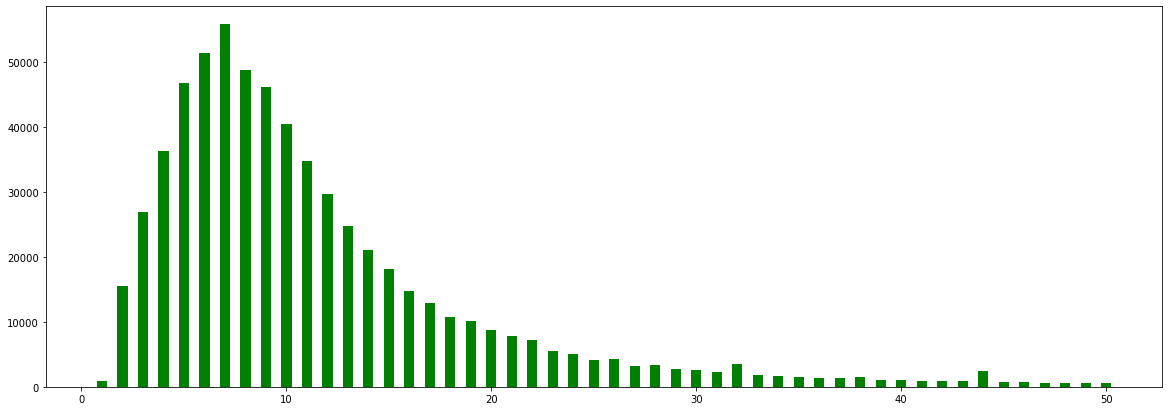

In [176]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


def plot_len_texts(tokenized_texts):
    list_lens = [len(tokenized_text) for tokenized_text in tokenized_texts]
    d = Counter(list_lens)
    
    tuple_list = [(k,l) for k,l in sorted([(i,j) for i,j in d.items()], reverse=False)]
    #print(tuple_list)
    plt.figure(figsize=(20, 7))
    plt.bar([t[0] for t in tuple_list[:50]], [t[1] for t in tuple_list[:50]], width=0.5, color='g')
    
plot_len_texts(df_all['text_tokenized'].to_list())

<BarContainer object of 100 artists>

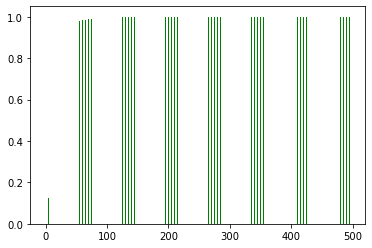

In [177]:
x = []
y = []
for i in range(0,500, 5):
    R = list(filter(lambda x: 0 < len(x) < i, df['text_tokenized'].to_list()))
    #print(i, len(R), round(len(R)/len(df), 2))
    x.append(i)
    y.append(len(R)/len(df_all))

plt.bar(x, y, width=0.5, color='g')

In [147]:
# from langdetect import detect
# df['lang'] = df['text'].progress_apply(detect)

In [178]:
df_all['len'] = df_all['text_tokenized'].apply(len)

In [179]:
df_all_2 = df_all[df_all['len'] > 100]

In [180]:
df_all_2.head()

,id,catalogues,positions,text,tag,text_tokenized,len
460,10678944,[33],"[42, 48]","Программирование: ASP, ASP.net, C/C++, CSS, HT...",requirements,"[Программирование, :, ASP, ,, ASP, ., net, ,, ...",105
469,10689730,[33],"[48, 53, 60]",В/о (инженерное и математическое в области ИТ)...,requirements,"[В, /, о, (, инженерное, и, математическое, в,...",103
509,10697014,[33],"[48, 60]",Для участия в конкурсе представляются: личное ...,requirements,"[Для, участия, в, конкурсе, представляются, :,...",111
556,10709952,[33],"[37, 48, 51, 57, 60]",- копии документов о профессиональном образова...,requirements,"[-, копии, документов, о, профессиональном, об...",241
731,10763067,[33],[48],Важные личные качества: умение работать в кома...,requirements,"[Важные, личные, качества, :, умение, работать...",112


In [190]:
type(df_all_2.iloc[0]['positions'])

list

In [193]:
df_all_2['len_pos'] = df_all_2['positions'].progress_apply(len)

<ipython-input-193-46eae0ad405c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_2['len_pos'] = df_all_2['positions'].progress_apply(len)


In [202]:
df_48 = df_all_2[df_all_2['len_pos']==1]
df_48['main_pos'] = df_48['positions'].apply(lambda x: x[0])
df_48 = df_48[df_48['main_pos']==48]
df_48.head()

<ipython-input-202-240987bf9505>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_48['main_pos'] = df_48['positions'].apply(lambda x: x[0])


,id,catalogues,positions,text,tag,text_tokenized,len,len_pos,main_pos
731,10763067,[33],[48],Важные личные качества: умение работать в кома...,requirements,"[Важные, личные, качества, :, умение, работать...",112,1,48
2711,10924843,[33],[48],Х от 1 года * Высокая степень ответственности ...,requirements,"[Х, от, 1, года, *, Высокая, степень, ответств...",132,1,48
2932,10942024,[33],[48],* 2-3 years experience with J2EE application d...,requirements,"[*, 2-3, years, experience, with, J, 2, EE, ap...",159,1,48
7986,12050240,[33],[48],Hands-on experience with UNIX platforms (SunOS...,requirements,"[Hands-on, experience, with, UNIX, platforms, ...",102,1,48
12875,12100718,[33],[48],- опыт разработки приложений с применением .Ne...,requirements,"[-, опыт, разработки, приложений, с, применени...",101,1,48


In [203]:
len(df_48)

180

In [181]:
for i in df_all_2.text.to_list():
    print(i)
    print(20*'=')

Программирование: ASP, ASP.net, C/C++, CSS, HTML, Java, JavaScript/VBScript, MS asp.net, MS C#, MS FoxPro, MS VB.net, MS VBA, MS Visual Basic, MS Visual C++, MS Visual C++.NET, MS Visual Studio, MS Visual Studio.NET, PERL, XML/WebServices БД: MS Access, MS SQL Server, mySQL, Oracle, SQL, ERM: Axapta, MySAP, Navision, SAP, SAP CRM,
В/о (инженерное и математическое в области ИТ), обязательно наличие сертификатов по 1С ЗиК 7.7, 1С Предприятие 8.0 ЗУП, свободное знание ПК, опыт работы от 5-ти лет в области разработки ПО в области бухгалтерского учета и расчета заработной платы с использованием программного обеспечения 1С, желателен опыт работы с MS SQL 2000/2005, приветствуется опыт участия в разработке проекта по внедрению ПО 1С ЗиК 7.7 или ПО 1С Предприятие 8.0 на крупном предприятии, обязательно знание расчета заработной платы, бухгалтерского учета, знание языка программирования 1С 7.7.Требования:
Для участия в конкурсе представляются: личное заявление; собственноручно заполненная и под

1. Знание 1С на уровне эксперта (конфигурации: «Управление торговлей», «Бухгалтерия», «Зарплата и управление персоналом», желательно «Управление производственным предприятием»; 2. Хорошее знание бухгалтерского и налогового учета РФ; 3. Знание (понимание) возможностей интеграции 1С с другим ПО. 4. Профильное образование (высшее, среднее техническое, экономическое) по специальностям: АСУ, программирование, экономика и Опыт работы по указанным задачам от 3-х лет в торговых и производственных компаниях со штатом не менее 300 человек; 5. Личные качества: умение мыслить системно, умение работать с внутренними заказчиками (работниками финансово-экономической службы, торговых подразделений), управленческие навыки, умение работать в режиме многозадачности, ориентация на результат.
1. Знание 1С на уровне эксперта (конфигурации: «Управление торговлей», «Бухгалтерия», «Зарплата и управление персоналом», желательно «Управление производственным предприятием»; 2. Хорошее знание бухгалтерского и налог

Высшее образование, сертификат 1С, опыт работы не менее 5 лет, знание 1С-Битрикс на уровне написания собственных компонентов и модулей с использованием внутреннего API, знание архитектуры 1С-Bitrix, знание HTML и CSS, PHP и MySQL, умение разбираться в коде приобретенного ПО, знание встроенного языка программирования 1С, знание конфигураций системы 1С: версия 8.2 или 8.3., опыт настройки, доработки существующих и создание новых компонентов системы 1С: версий 8.х.: интерфейсов, справочников, отчетов, документов, обработок; опыт сбора требований на настройку, доработку существующих компонентов системы 1С и разработку новых компонентов, опыт согласования требований различных служб и разработки технических заданий, обязательное знание языка программирования 1С, желательно знание языка программирования 1С-Bitrix/
Знание и опыт администрирования: o Microsoft Forefront TMG o Системы виртуализации Vmware vSphere 5.x;6.х o Windows Server 2003-2012 (IIS, DNS, DHCP, AD, File services, WSUS, Print 

▪ Образование: высшее; ▪ Опыт работы от одного года в IT; ▪ Опыт работы с системами автоматизации служб Help Desk / Service Desk будет являться преимуществом; ▪ Знание основ ITSM/ITIL/MOF (по выбору); ▪ Базовые знания AD, DHCP, TCP/IP, LAN, GPO, Wi-Fi, компьютерного железа; ▪ Уверенные знания семейства операционных систем Microsoft Windows XP, Windows 7, Windows 8 (на уровне администратора локальной системы); ▪ Профессиональное владение инструментами продуктов Microsoft MS Office 2003/ 2007 / 2010 / 2013; ▪ Понимание принципов работы сетевого оборудования и внутреннего устройства компьютерной сети; ▪ Базовые знания серверных операционных систем Microsoft Server 2003 и 2008, 2012; ▪ Опыт написание запросов на SQL, PLSQL; ▪ Знание порядка ведения и оформления технической документации; ▪ Базовые знания английского языка, достаточные для чтения технической литературы; ▪ Личные качества: аналитический склад ума, системный подход к решению сложных задач; уметь ясно излагать свои мысли, комму

их построения;</p><p>
3 лет;</p></li><li><p>Разработка
на React (Redux/Mobx, Webpack) от 3 лет;</p></li><li><p>Опыт работы в
высоконагруженных проектах;</p></li><li><p>Опыт
написания юнит-тестов;</p></li><li><p>Знание git на уровне git rebase --interactive и git push --force-with-lease;</p></li><li><p>Опыт работы с СУБД;</p></li><li><p>Кроссбраузерная
и кроссплатформенная вёрстка;</p></li><li>Знание HTML,
CSS, понимание и знание препроцессоров, постпроцессоров, css-modules, BEM;
You will be surrounded by cutting-edge
technology, given immediate responsibility, all to provide you with the best
possible environment to succeed.</p><p>We're
looking for someone who loves technology and wants to work on a broad range of
projects using various tool(s) to best solve the problem at hand. Excellent
communication is a must, along with a can-do attitude.</p></li><li><p><b>Constant
Capital </b>is a global
wealth manager, offering its HNW clients bespoke investment solutions across a
number of secto

In [154]:
import re
df2['pattern'] = df2['text'].apply(lambda x: len(re.findall(r'^\d\.\s|\s\d\.\s', x)))
df2.head()

<ipython-input-154-11308fa2411b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pattern'] = df2['text'].apply(lambda x: len(re.findall(r'^\d\.\s|\s\d\.\s', x)))


,id,text,text_tokenized,tag,len,pattern
460,10678944,"Программирование: ASP, ASP.net, C/C++, CSS, HT...","[Программирование, :, ASP, ,, ASP, ., net, ,, ...",requirements,105,0
469,10689730,В/о (инженерное и математическое в области ИТ)...,"[В, /, о, (, инженерное, и, математическое, в,...",requirements,103,0
509,10697014,Для участия в конкурсе представляются: личное ...,"[Для, участия, в, конкурсе, представляются, :,...",requirements,111,0
556,10709952,- копии документов о профессиональном образова...,"[-, копии, документов, о, профессиональном, об...",requirements,241,0
731,10763067,Важные личные качества: умение работать в кома...,"[Важные, личные, качества, :, умение, работать...",requirements,112,0


In [155]:
df3 = df2[df2['pattern']>0]
df3.head()

,id,text,text_tokenized,tag,len,pattern
1310,10836346,Хорошее знание существующих на сей день технол...,"[Хорошее, знание, существующих, на, сей, день,...",requirements,142,8
2502,10908063,1. опыт работы аналитиком; 2. владение методик...,"[1, ., опыт, работы, аналитиком, ;, 2, ., влад...",requirements,105,9
2684,10923687,Required skills: 1. Minimum of 3 years as a DB...,"[Required, skills, :, 1, ., Minimum, of, 3, ye...",requirements,114,5
3781,10991842,Опыт работы от 3-х лет. 1. Знание структуры и ...,"[Опыт, работы, от, 3-х, лет, ., 1, ., Знание, ...",requirements,106,7
3783,10991847,Опыт работы от 3-х лет. 1. Знание структуры и ...,"[Опыт, работы, от, 3-х, лет, ., 1, ., Знание, ...",requirements,106,7


In [157]:
for i in df3.text.to_list():
    print(i)
    print()

Хорошее знание существующих на сей день технологий и понимание перспективных технологий 4. Решение комплексных, многофункциональных, перекрестных вопросов 5. Опыт реагирования на инциденты в системе компьютерной безопасности Требования к навыкам и опыту: 1. Отличные навыки письменного и устного общения, восприятия речи на слух, переговорные навыки и навыки подачи (презентации) материала. 2. Способность работать эффективно, в качестве члена единой команды приумножать эффект ее работы и уметь принимать лидерство. 3. Уметь продемонстрировать технические знания и навыки консультирования 4. Способность обучать и передавать знания и информацию среди коллег по цеху. 5. Технические знания и навыки консультирования должны быть столь совершенны, чтобы не к чему было придраться 6. Способность охватить комплексность и глубину технической проблемы, умение решить проблему и получить/изыскать необходимые для этого ресурсы

1. опыт работы аналитиком; 2. владение методиками описания и моделирования биз

In [168]:
segmentator = SentenceSegmentator() 

long_texts = []
for d in tqdm(duties[:1000]): 
    if len(list(tokenize(d)))>20:
        long_texts.append(d)

print(len(long_texts))


for lt in long_texts:
    for sent in segmentator.split(lt):
        print(sent)
        print('='*20)


167
Разработка и отладка технологических программ контроллеров (АРМ операторов) в проектах автоматизации водогрейных и паровых котлов малой и средней мощности.
Администрирование серверов, сети, ActivDirectory, пользовательские приложения, копирование дисков, создание нового пользователя, работа по заявкам пользователей, документирование работы
Если вы хотите внести свой вклад в информационную безопасность и чувствуете в себе дух исследователя — эта вакансия для вас.
Необходимо отслеживать общее состояние техники у клиента и выдавать своевременные рекомендации, участие в финансовом документообороте (доставка оригиналов документов).
Настойка Тестовых стендов, подключение телекоммуникационного оборудования Установка и настройка ОС Windows XP, Seven, 2003 Server, 2008 Server, Поддержка виртуальных машин на VMware server, Проведение функционального и нагрузочного тестирования, Анализ результатов тестирования, написания тестовой документации.
При необходимости принимать участие в согласован

In [153]:
requirements[:100]

['- Администрирование и развитие серверов баз данных под управлением MS SQL Server 2005/2008;',
 '- знание методов построения отказоустойчивых систем на базе MS SQL Server 2005/2008;',
 '- администрирование ОС Windows 2003/2008, администрирование AD, DNS, DHCP, DFS, Print Services, Terminal Services;',
 '- опыт написания скриптов на VBScript/PowerShell;',
 '- администрирование MS Exchange 2003/2007/2010;',
 '- знание технологии Windows Failover Clustering;',
 '- администрирование VMWARE.',
 'Будет считаться плюсом знание или знакомство с:',
 '- оборудованием Cisco, Avaya, Nortel;',
 '- оборудованием СХД EMC;',
 '- оборудованием СХД Hitachi;',
 '- FreeBSD; Установка и администрирование Postfix, Zabbix и других приложений под nix;',
 '- системами мониторинга Zabbix или Nagios.',
 'Опыт работы в соответствующей должности.',
 'Способность быстро разбираться в чужом коде.',
 '- опыт работы программистом не менее 2 лет;',
 '- знание Assembler x86 на уровне написания больших проектов;',
 '- в

In [151]:
lst_d[:15], lst_r[:15], lst_c[:15]

([(',', 405440),
  ('и', 326214),
  ('.', 312068),
  (';', 211455),
  ('-', 163445),
  ('в', 146134),
  ('с', 127625),
  ('•', 119486),
  ('по', 102071),
  (')', 86928),
  ('(', 84769),
  ('на', 80766),
  ('разработка', 55724),
  ('1', 54410),
  ('пользователей', 45065)],
 [(',', 602015),
  ('.', 345965),
  (';', 275529),
  ('и', 233435),
  ('опыт', 215411),
  ('-', 209946),
  ('с', 173770),
  ('•', 170921),
  ('знание', 161664),
  ('работы', 143858),
  ('в', 139210),
  (')', 129365),
  ('(', 126901),
  (':', 89119),
  ('1', 81022)],
 [('.', 363409),
  (',', 311917),
  (';', 217232),
  ('-', 168084),
  ('в', 167313),
  ('и', 129973),
  ('•', 116413),
  (':', 107380),
  ('с', 105918),
  ('работы', 85031),
  ('по', 84553),
  (')', 83136),
  ('(', 82985),
  ('тк', 62536),
  ('на', 60342)])

In [85]:
!pip install pymorphy2

  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=34af844d98d154a2e7cb4d2e8280c54eae01555061baa9ad39045b70c13a5198
  Stored in directory: c:\users\ivan\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [112]:
import spacy_udpipe

spacy_udpipe.download("ru") # download English model

#"ru": "russian-gsd-ud-2.4-190531.udpipe",
#"ru-syntagrus": "russian-syntagrus-ud-2.4-190531.udpipe",
#"ru-taiga": "russian-taiga-ud-2.4-190531.udpipe",

Already downloaded a model for the 'ru' language


In [118]:
#text = '''Президент России Владимир Путин поговорил по телефону с турецким лидером Реджепом Тайипом Эрдоганом.'''
#text = '''Премьер-министр России Дмитрий Медведев поручил навести порядок в деятельности экскурсоводов, гидов-переводчиков, инструкторов и проводников.'''
text = df2.text.to_list()[0]

nlp = spacy_udpipe.load("ru")

doc = nlp(text)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_)

for w in doc:
    print(w.text, w.dep_, w.head, w.i, w.head.i)

Программирование программирование NOUN ROOT
: : PUNCT punct
ASP ASP PROPN parataxis
, , PUNCT punct
ASP.net ASP.net PROPN flat:foreign
, , PUNCT punct
C/C++ C/C++ PUNCT conj
, , PUNCT punct
CSS CSS PROPN flat:foreign
, , PUNCT punct
HTML html PROPN flat:foreign
, , PUNCT punct
Java Java PROPN flat:foreign
, , PUNCT punct
JavaScript JavaScript PROPN flat:foreign
/ / PUNCT punct
VBScript VBScript PROPN flat:foreign
, , PUNCT punct
MS MS PROPN flat:foreign
asp.net asp.net X flat:foreign
, , PUNCT punct
MS MS PROPN flat:foreign
C C PROPN flat:foreign
# # PUNCT acl
, , PUNCT punct
MS MS PROPN flat:foreign
FoxPro FoxPro PROPN flat:foreign
, , PUNCT punct
MS MS PROPN flat:foreign
VB.net VB.net PROPN flat:foreign
, , PUNCT punct
MS MS PROPN flat:foreign
VBA VBA PROPN flat:foreign
, , PUNCT punct
MS MS PROPN flat:foreign
Visual Visual PROPN flat:foreign
Basic Basic PROPN flat:foreign
, , PUNCT punct
MS MS PROPN flat:foreign
Visual Visual PROPN flat:foreign
C++ C++ PUNCT conj
, , PUNCT punct
MS 

In [119]:
nodes = [w.text for w in doc]
nodes_n = [w.i for w in doc]

edges_n = [[w.i, w.head.i] for w in doc]
edges_t = [[w.text, w.head.text] for w in doc]
edges_labels = {(w.text,w.head.text):w.dep_ for w in doc}


print(nodes)
print(nodes_n)
print(edges_n)
print(edges_t)
print(edges_labels)

['Программирование', ':', 'ASP', ',', 'ASP.net', ',', 'C/C++', ',', 'CSS', ',', 'HTML', ',', 'Java', ',', 'JavaScript', '/', 'VBScript', ',', 'MS', 'asp.net', ',', 'MS', 'C', '#', ',', 'MS', 'FoxPro', ',', 'MS', 'VB.net', ',', 'MS', 'VBA', ',', 'MS', 'Visual', 'Basic', ',', 'MS', 'Visual', 'C++', ',', 'MS', 'Visual', 'C++.NET', ',', 'MS', 'Visual', 'Studio', ',', 'MS', 'Visual', 'Studio.NET', ',', 'PERL', ',', 'XML', '/', 'WebServices', 'БД', ':', 'MS', 'Access', ',', 'MS', 'SQL', 'Server', ',', 'mySQL', ',', 'Oracle', ',', 'SQL', ',', 'ERM', ':', 'Axapta', ',', 'MySAP', ',', 'Navision', ',', 'SAP', ',', 'SAP', 'CRM', ',']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
[[0, 0], [1, 0], [2, 0], [3, 4

In [120]:
#%%
def get_n_root(doc):
    for word in doc:
        if(word.dep_ == 'ROOT'):
            return word.i
def get_list_sons_by_parent(doc, parent):
    if(parent == -1):
        list_ = [-1]
        return list_
    list_ = []
    for word in doc:
        if(word.head.i == parent)and(word.i != parent):
            list_.append(word.i)
    if(list_==[]):
        list_ = [-1]
    return list_
def get_list_sons_by_parents(doc, parents):
    list_ = []
    for parent in parents:
        list_.extend(get_list_sons_by_parent(doc, parent))
    #if(list_==[]):
    #    list_=['none']
    return list_

def is_all_els_ends(list_):
    for i in list_:
        if(i!=-1):
            return False
    return True

def get_nodes_by_levels(parent):
    list_ = []
    parents = [parent]
    for i in range(10):
    #while(is_all_els_ends(parents)==False):
        list_.append(parents)
        #print(parents)
        for p in parents:
            #print(doc[p].text)
            pass
        parents = get_list_sons_by_parents(doc,parents)
    #print(list_)
    return list_

def get_max_level(list_):
    print(list_)
    try:
        return max([len(level) for level in list_])
    except:
        return -1
levels = get_nodes_by_levels(get_n_root(doc))
print(levels)
print(get_max_level(levels))

[[0], [1, 2, 86], [-1, 4, 6, -1], [-1, 3, 5, 8, 10, 12, 14, 23, -1], [-1, -1, -1, 7, 9, 11, 13, 15, 25, 26, 28, 29, 31, 32, 34, 35, 36, 38, 39, 40, -1], [-1, -1, -1, -1, -1, -1, -1, 16, 18, 19, 21, 22, 24, -1, 27, -1, 30, -1, 33, -1, -1, 37, -1, 42, 43, 44, 46, 47, 48, 50, 51, 52, 54, 56, 58, 59, 60, 61, -1], [-1, -1, -1, -1, -1, -1, -1, -1, 17, -1, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 41, -1, -1, 45, -1, -1, 49, -1, -1, 53, 55, 57, -1, -1, 62, 64, 65, 66, 68, 70, 72, 74, 75, 76, 78, 80, 82, 84, 85, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 63, -1, -1, 67, 69, 71, 73, -1, -1, 77, 79, 81, 83, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [121]:
def orientation(list_,mode=1):
    w = 500
    h = 200

    pos = {}

    if mode==1:
        max_block = get_max_level(get_nodes_by_levels(get_n_root(doc)))
        for i in range(len(list_)):
            w0 = -(w * max_block) / 2
            for j in range(len(list_[i])):
                block = get_max_level(get_nodes_by_levels(list_[i][j]))
                print(block, end = ' ')
                # #print(list_[i], end = ' ')
                print(w0, end = ' ')
                pos[list_[i][j]] = (w0 + (block*w)/2, -i*h)
                w0 = w0 + (block*w)
            print(f"({max_block})")
    elif mode==2:
        for i in range(len(list_)):
            for j in range(len(list_[i])):
                w0 = -((len(list_[i])-1)*w)/2
                pos[list_[i][j]] = (w0 + j*w, -i*h)

    elif mode==3:
        for i in range(len(list_)):
            for j in range(len(list_[i])):
                h0 = -((len(list_[i])-1)*h)/2
                pos[list_[i][j]] = (i*w, h0 + j*h)
    return pos

pos = orientation(levels,1)
print(pos)

[[0], [1, 2, 86], [-1, 4, 6, -1], [-1, 3, 5, 8, 10, 12, 14, 23, -1], [-1, -1, -1, 7, 9, 11, 13, 15, 25, 26, 28, 29, 31, 32, 34, 35, 36, 38, 39, 40, -1], [-1, -1, -1, -1, -1, -1, -1, 16, 18, 19, 21, 22, 24, -1, 27, -1, 30, -1, 33, -1, -1, 37, -1, 42, 43, 44, 46, 47, 48, 50, 51, 52, 54, 56, 58, 59, 60, 61, -1], [-1, -1, -1, -1, -1, -1, -1, -1, 17, -1, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 41, -1, -1, 45, -1, -1, 49, -1, -1, 53, 55, 57, -1, -1, 62, 64, 65, 66, 68, 70, 72, 74, 75, 76, 78, 80, 82, 84, 85, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 63, -1, -1, 67, 69, 71, 73, -1, -1, 77, 79, 81, 83, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

1 -4250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -3750.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -3250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -2750.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -2250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -1750.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -1250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -750.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 -250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 750.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 1250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 1750.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 2250.0 [[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]
1 2750.0 [[-1],

[(0, 0, 'ROOT'), (1, 0, 'punct'), (2, 0, 'parataxis'), (3, 4, 'punct'), (4, 2, 'flat:foreign'), (5, 6, 'punct'), (6, 2, 'conj'), (7, 8, 'punct'), (8, 6, 'flat:foreign'), (9, 10, 'punct'), (10, 6, 'flat:foreign'), (11, 12, 'punct'), (12, 6, 'flat:foreign'), (13, 14, 'punct'), (14, 6, 'flat:foreign'), (15, 23, 'punct'), (16, 15, 'flat:foreign'), (17, 18, 'punct'), (18, 15, 'flat:foreign'), (19, 15, 'flat:foreign'), (20, 21, 'punct'), (21, 15, 'flat:foreign'), (22, 15, 'flat:foreign'), (23, 6, 'acl'), (24, 25, 'punct'), (25, 23, 'flat:foreign'), (26, 23, 'flat:foreign'), (27, 28, 'punct'), (28, 23, 'flat:foreign'), (29, 23, 'flat:foreign'), (30, 31, 'punct'), (31, 23, 'flat:foreign'), (32, 23, 'flat:foreign'), (33, 34, 'punct'), (34, 23, 'flat:foreign'), (35, 23, 'flat:foreign'), (36, 23, 'flat:foreign'), (37, 38, 'punct'), (38, 23, 'flat:foreign'), (39, 23, 'flat:foreign'), (40, 23, 'conj'), (41, 42, 'punct'), (42, 40, 'flat:foreign'), (43, 40, 'flat:foreign'), (44, 40, 'flat:foreign'), 

{(0, 0): Text(0.0, 0.0, 'ROOT'),
 (1, 0): Text(-6500.0, -100.0, 'punct'),
 (2, 0): Text(0.0, -100.0, 'parataxis'),
 (3, 4): Text(-12500.0, -500.0, 'punct'),
 (4, 2): Text(-6250.0, -300.0, 'flat:foreign'),
 (5, 6): Text(-5875.0, -500.0, 'punct'),
 (6, 2): Text(125.0, -300.0, 'conj'),
 (7, 8): Text(-11500.0, -700.0, 'punct'),
 (8, 6): Text(-5625.0, -500.0, 'flat:foreign'),
 (9, 10): Text(-11000.0, -700.0, 'punct'),
 (10, 6): Text(-5375.0, -500.0, 'flat:foreign'),
 (11, 12): Text(-10500.0, -700.0, 'punct'),
 (12, 6): Text(-5125.0, -500.0, 'flat:foreign'),
 (13, 14): Text(-10000.0, -700.0, 'punct'),
 (14, 6): Text(-4875.0, -500.0, 'flat:foreign'),
 (15, 23): Text(-3500.0, -700.0, 'punct'),
 (16, 15): Text(-9000.0, -900.0, 'flat:foreign'),
 (17, 18): Text(-9000.0, -1100.0, 'punct'),
 (18, 15): Text(-8750.0, -900.0, 'flat:foreign'),
 (19, 15): Text(-8500.0, -900.0, 'flat:foreign'),
 (20, 21): Text(-8000.0, -1100.0, 'punct'),
 (21, 15): Text(-8250.0, -900.0, 'flat:foreign'),
 (22, 15): Text(-

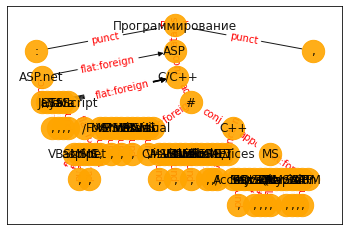

In [127]:
pair_list = []

for w in doc:
    pair_list.append((w.i, w.head.i, w.dep_))

print(pair_list)


import networkx as nx
G=nx.DiGraph()
for pair in pair_list:
    G.add_edge(pair[0], pair[1], weight=pair[2], title=str(pair[2]))

edge_labels = nx.get_edge_attributes(G, 'title')
print(edge_labels)
#
# fig = plt.figure()
# #ax1 = plt.subplot2grid((1, 1), (0, 0))
# #pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True)
#
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# plt.show()
#
# print(pos)



labels_edges = {(pair[0],pair[1]):str(pair[2]) for pair in pair_list}

print(labels_edges)


node_labels = {w.i:w.text for w in doc}

print(node_labels)

nx.draw_networkx(G, pos, label = 'NetworkX', width=1, linewidths=1, node_size=500, node_color='orange',alpha=0.9, arrows = True, labels=node_labels, with_labels = True)


#nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()})
nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=labels_edges,
                             font_color='red',
                             label_pos = 0.50)
#plt.show()
#plt.savefig('fig.png')

In [124]:
text

'Программирование: ASP, ASP.net, C/C++, CSS, HTML, Java, JavaScript/VBScript, MS asp.net, MS C#, MS FoxPro, MS VB.net, MS VBA, MS Visual Basic, MS Visual C++, MS Visual C++.NET, MS Visual Studio, MS Visual Studio.NET, PERL, XML/WebServices БД: MS Access, MS SQL Server, mySQL, Oracle, SQL, ERM: Axapta, MySAP, Navision, SAP, SAP CRM,'

In [123]:
!pip install graphviz

[['-', 'знание'], ['знание', 'знание'], ['методов', 'знание'], ['построения', 'методов'], ['отказоустойчивых', 'систем'], ['систем', 'построения'], ['на', 'базе'], ['базе', 'построения'], ['MS', 'базе'], ['SQL', 'базе'], ['Server', 'базе'], ['2005', 'базе'], ['/', '2008'], ['2008', '2005'], [';', 'знание']]


{('-', 'знание'): Text(0.1453908360455709, -0.8732004778287317, 'punct'),
 ('знание', 'знание'): Text(0.07496627951322518, -0.7709188219159632, 'ROOT'),
 ('методов', 'знание'): Text(0.058870027578706005, -0.591538405646909, 'nmod'),
 ('построения',
  'методов'): Text(0.02663711821761206, -0.2158604603015538, 'nmod'),
 ('отказоустойчивых',
  'систем'): Text(-0.3326134420594389, 0.31464474581341095, 'amod'),
 ('систем',
  'построения'): Text(-0.12106621040765994, 0.08962352062496393, 'nmod'),
 ('на', 'базе'): Text(0.32399238426757726, 0.22461112016636126, 'case'),
 ('базе', 'построения'): Text(0.11169174822402196, 0.1356036815100219, 'nmod'),
 ('MS', 'базе'): Text(0.3516092436949919, 0.32197404925996914, 'flat:foreign'),
 ('SQL',
  'базе'): Text(0.29957952327130305, 0.4032368676801734, 'flat:foreign'),
 ('Server',
  'базе'): Text(0.2042472709520185, 0.42486578976643086, 'flat:foreign'),
 ('2005', 'базе'): Text(0.041225876437276404, 0.2780841091814058, 'nummod'),
 ('/', '2008'): Text(-0.6

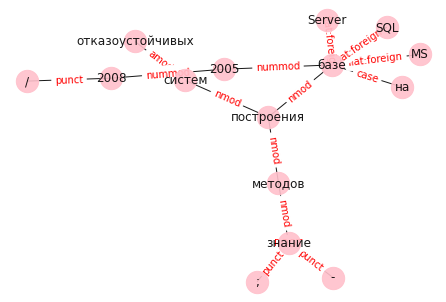

In [126]:
print(edges_t)

#%%
import networkx as nx
G=nx.Graph()
G.add_edges_from(edges_t)
pos = nx.spring_layout(G)
#plt.figure()
nx.draw(G,pos,edge_color='black',width=1,linewidths=1, node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in G.nodes()},with_labels = True)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edges_labels,font_color='red')


#%%

# import networkx as nx
# from networkx.drawing.nx_agraph import write_dot, graphviz_layout
# import matplotlib.pyplot as plt
# G = nx.DiGraph()
#
# G.add_node("ROOT")
#
# for i in range(5):
#     G.add_node("Child_%i" % i)
#     G.add_node("Grandchild_%i" % i)
#
#     G.add_node("Greatgrandchild_%i" % i)
#
#     G.add_edge("ROOT", "Child_%i" % i)
#     G.add_edge("Child_%i" % i, "Grandchild_%i" % i)
#     G.add_edge("Grandchild_%i" % i, "Greatgrandchild_%i" % i)
#
# # write dot file to use with graphviz
# # run "dot -Tpng test.dot >test.png"
# write_dot(G,'test.dot')
#
# # same layout using matplotlib with no labels
# plt.title('draw_networkx')
# pos =graphviz_layout(G, prog='dot')
# nx.draw(G, pos, with_labels=False, arrows=True)
# plt.savefig('nx_test.png')

In [127]:
#%%

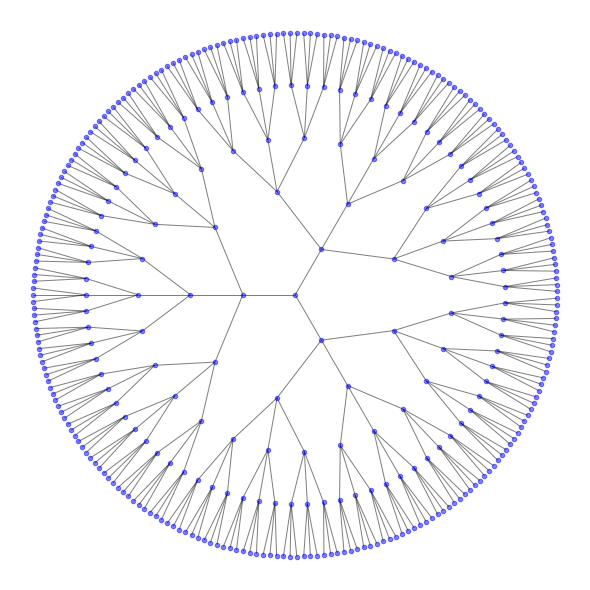

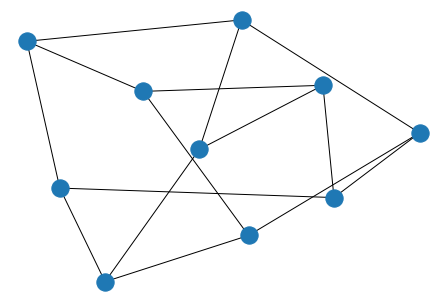

In [128]:
import matplotlib.pyplot as plt
import networkx as nx

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

G = nx.balanced_tree(3, 5)
pos = graphviz_layout(G, prog='twopi')
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=False)
plt.axis('equal')
plt.show()


import networkx as nx
import matplotlib.pyplot as plt
g1 = nx.petersen_graph()
nx.draw(g1)

#plt.show()
#%%

{('A', 'B'): Text(0.4417143748625415, 0.2351168808780954, 'AB'),
 ('B', 'C'): Text(-0.01930977039717673, -0.4999663038684783, 'BC'),
 ('B', 'D'): Text(-0.42246845297893343, 0.2649168152534263, 'BD')}

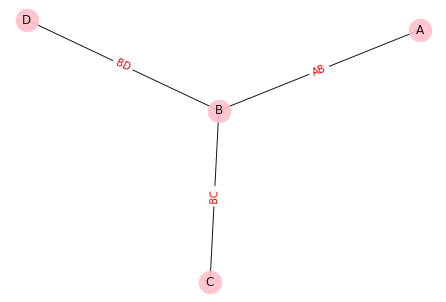

In [110]:
import networkx as nx
edges=[['A','B'],['B','C'],['B','D']]
G=nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
#plt.figure()
nx.draw(G,pos,edge_color='black',width=1,linewidths=1, node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos,edge_labels={('A','B'):'AB',('B','C'):'BC',('B','D'):'BD'},font_color='red')
#plt.axis('off')
#plt.show()

In [96]:
import re
text = "1. Разработка мобильного приложения 2. Интеграция с различными банковскими приложениями 3. Разработка бизнес-логики, участие в проектировании"

result = re.findall(r'^\d\.\s|\s\d\.\s', text)
print(result)

['1. ', ' 2. ', ' 3. ']


In [116]:
df = (pd.DataFrame({'name': ['A.J. Price'] * 3, 
                    'opponent': ['76ers', 'blazers', 'bobcats'], 
                    'nearest_neighbors': [['Zach LaVine', 'Jeremy Lin', 'Nate Robinson', 'Isaia']] * 3})
      .set_index(['name', 'opponent']))

In [117]:
df.head()

nearest_neighbors
name       opponent                                                 
A.J. Price 76ers     [Zach LaVine, Jeremy Lin, Nate Robinson, Isaia]
           blazers   [Zach LaVine, Jeremy Lin, Nate Robinson, Isaia]
           bobcats   [Zach LaVine, Jeremy Lin, Nate Robinson, Isaia]

In [112]:
df.reset_index(inplace=True)

In [121]:
pd.melt(df.nearest_neighbors.apply(pd.Series).reset_index(), 
             id_vars=['name', 'opponent'],
             value_name='nearest_neighbors').set_index(['name', 'opponent']).drop('variable', axis=1).dropna().sort_index()

nearest_neighbors
name       opponent                  
A.J. Price 76ers          Zach LaVine
           76ers           Jeremy Lin
           76ers        Nate Robinson
           76ers                Isaia
           blazers        Zach LaVine
           blazers         Jeremy Lin
           blazers      Nate Robinson
           blazers              Isaia
           bobcats        Zach LaVine
           bobcats         Jeremy Lin
           bobcats      Nate Robinson
           bobcats              Isaia

In [122]:
d = {'date': ['4/1/11', '4/2/11'], 'ts': [[pd.Timestamp('2012-02-29 00:00:00'), pd.Timestamp('2012-03-31 00:00:00'), pd.Timestamp('2012-04-25 00:00:00'), pd.Timestamp('2012-06-30 00:00:00')], [pd.Timestamp('2014-01-31 00:00:00')]]}
df = pd.DataFrame(d)

In [123]:
df.head()

,date,ts
0,4/1/11,"[2012-02-29 00:00:00, 2012-03-31 00:00:00, 201..."
1,4/2/11,[2014-01-31 00:00:00]


In [124]:
df_new = df.groupby('date').ts.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)
df_new.columns = ['date','ts']
df_new.head()

,date,ts
0,4/1/11,2012-02-29
1,4/1/11,2012-03-31
2,4/1/11,2012-04-25
3,4/1/11,2012-06-30
4,4/2/11,2014-01-31


In [204]:
import spacy_udpipe

spacy_udpipe.download("ru") # download English model

import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [206]:
!pip install spacy

In [207]:
!python -m spacy download en_core_web_sm

  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047113 sha256=85f384452bb50d7288934ae6cd44c738a9d6b020e8981871fbc11023d61df55d
  Stored in directory: C:\Users\Ivan\AppData\Local\Temp\pip-ephem-wheel-cache-dfc8jxhz\wheels\ee\4d\f7\563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [209]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019126 sha256=21a50df1faf30144ce121f371da22d7675b2d863b7afb69289e8c108c071f09b
  Stored in directory: c:\users\ivan\appdata\local\pip\cache\wheels\fc\31\e9\092e6f05b2817c9cb45804a3d1bf2b9bf6575742c01819337c
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.3.1
    Uninstalling en-core-web-sm-2.3.1:
      Successfully uninstalled en-core-web-sm-2.3.1


In [212]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [229]:
import re
import pandas as pd
import spacy
from tqdm import tqdm
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string 
tqdm._instances.clear()

  0%|                                                                                         | 0/4318 [00:50<?, ?it/s]


In [213]:
data_dir = "wiki_sentences_v2.csv"
sentences = pd.read_csv(data_dir)
sentences.shape

(4318, 1)

In [214]:
sentences.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [215]:
sentences[sentences['sentence'].str.contains('bollywood' and 'contemporary')]

,sentence
1021,"contemporary real-life serial killings have been portrayed in the alphabet killer, ed gein, gacy, ted bundy and dahmer."
1692,"contemporary bollywood dancers include madhuri dixit, hrithik roshan, aishwarya rai bachchan, sridevi, meenakshi seshadri, malaika arora khan, shahid kapoor, katrina kaif and tiger shroff."
1738,"contemporary bollywood dancers include madhuri dixit, hrithik roshan, aishwarya rai bachchan, sridevi, meenakshi seshadri, malaika arora khan, shahid kapoor, katrina kaif and tiger shroff."
2108,contemporary science fiction films continue to explore social and political issues.
2929,all the stories were set in contemporary england.
3355,and contemporary hollywood productions are shown on state television.
3386,and contemporary hollywood productions are shown on state television.
3613,"i, the series consists of colorized contemporary footage ."


In [216]:
def get_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      #Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix
      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
        #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + modifier

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]

In [217]:
[ent1,ent2] = get_entity("the film had 200 patents")
print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))
get_entity("the film had 200 patents")

Subj : film, obj : 200  patents


['film', '200  patents']

In [218]:
entity_pairs = []
for i in tqdm(sentences['sentence']):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:27<00:00, 49.51it/s]


In [219]:
subjects = []
objects = []
subjects = [x[0] for x in entity_pairs]
objects = [x[1] for x in entity_pairs]

In [220]:
def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'agent','OP':'?'},{'DEP':'ADJ','OP':'?'}]
  #Adding the pattern to the matcher
  matcher.add("matcher_1",None,pattern)
  #Applying the matcher to the doc
  matches = matcher(doc)

  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  span = doc[matches[0][1]:matches[0][2]]
  return span.text

In [221]:
get_entity("John completed the task"), get_relation("John completed the task")

(['John', 'task'], 'completed')

In [222]:
get_entity("John couldn't complete the task"), get_relation("John couldn't complete the task")

(['John', 'task'], 'complete')

In [223]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:22<00:00, 52.08it/s]


In [224]:
pd.Series(subjects).value_counts()[:10]

it       268
film     213
         156
he       141
they      69
i         65
this      57
she       38
we        26
films     25
dtype: int64

In [225]:
pd.Series(relations).value_counts()[:10]

is          425
was         339
released    170
are          98
were         88
include      81
produced     51
made         47
's           44
used         41
dtype: int64

In [230]:
def isNotStopWord(word):
    return word not in stopwords.words('english')

def preprocess(sent):
  sent = re.sub("[\(\[].*?[\)\]]", "", sent)
  tokens = []
  temp = ""
  words = word_tokenize(sent)
  # Removing punctuations except '<.>/<?>/<!>'
  punctuations = '"#$%&\'()*+,-/:;<=>@\\^_`{|}~'
  words = map(lambda x: x.translate(str.maketrans('','',punctuations)), words)
  
  #Now, we remove the stopwords
  words = map(str.lower,words)
  words = filter(lambda x: isNotStopWord(x),words)
  tokens = tokens + list(words)
  temp = ' '.join(word for word in tokens)
  return temp
preprocessed_sentences = [preprocess(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()

100%|█████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:38<00:00, 113.46it/s]


In [231]:
entity_pairs = []
for i in tqdm(preprocessed_sentences):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:22<00:00, 52.63it/s]


In [232]:
relations = [get_relation(i) for i in tqdm(preprocessed_sentences)]
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:26<00:00, 49.81it/s]


In [233]:
pd.Series(relations).value_counts()[:10]

released    188
include      82
produced     60
film         54
directed     53
made         49
used         40
became       39
began        35
included     34
dtype: int64

In [234]:
entity_pairs2 = entity_pairs
relations2 = relations
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████| 4318/4318 [00:00<00:00, 172755.59it/s]


In [235]:
source = []
target = []
edge = []
for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])

In [236]:
print("###################  Most popular source entites    ###################### \n",pd.Series(source).value_counts()[:10])
print("###################  Most popular target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Most popular relations         ###################### \n",pd.Series(relations).value_counts()[:20])

###################  Most popular source entites    ###################### 
                           202
film                       53
khan                       12
first  film                 8
series                      7
filming                     6
music                       6
indian  film                6
two certificate awards      5
award                       5
dtype: int64
###################  Most popular target entites    ###################### 
                                        223
warner bros                              9
national film awards                     5
rajat kamal cash prize                   5
white  zombie                            4
dual  1956                               4
positive box office success              4
imax  theaters                           4
toronto international film festival      4
time magazine                            4
dtype: int64
###################  Most popular relations         ###################### 
 released     

In [237]:
knowledge_graph_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})
knowledge_graph_df.head()
#MultiDIGRaph because its a directional graph

,source,target,edge
0,christian,,elder
1,c. mackenzie craig vincent,c. mackenzie cast,joined
2,later francia action bronson,later cast,revealed
3,sebastian maniscalco paul benvictor,later part,revealed
4,musician robbie robertson,musician soundtrack,supervised


In [238]:
knowledge_graph_df[knowledge_graph_df['source']=="khan"]

,source,target,edge
362,khan,first sharma film veer,release
363,khan,first 2011,release
367,khan,10 bigg boss,hosted
369,khan,,wheel
371,khan,bandra galaxy mumbai,resides
372,khan,actress katrina kaif,started
378,khan,first sharma film veer,release
379,khan,first 2011,release
383,khan,10 bigg boss,hosted
385,khan,,wheel


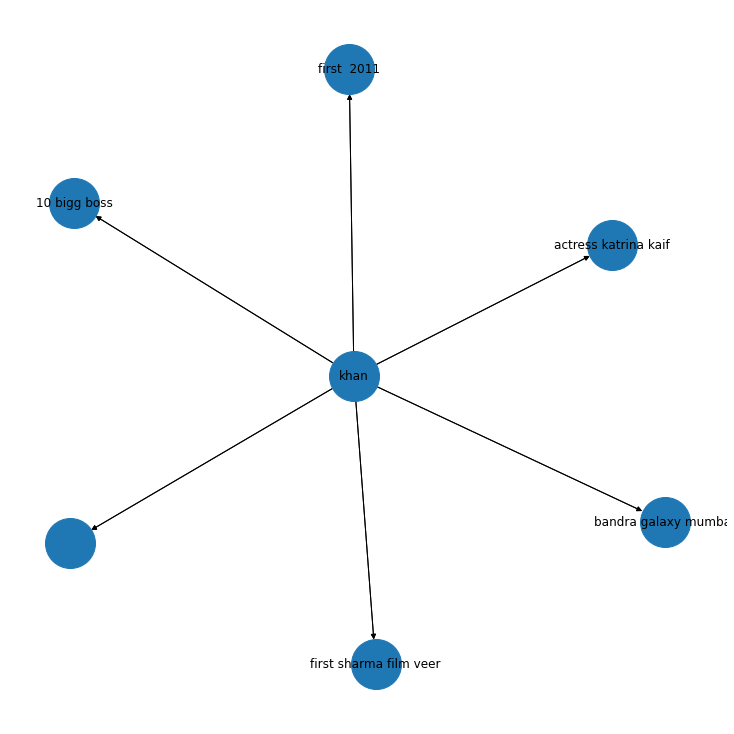

In [239]:
G = nx.from_pandas_edgelist(knowledge_graph_df[knowledge_graph_df['source']=="khan"],source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
#MultiDIGRaph because its a directional graph
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

In [240]:
knowledge_graph_df[knowledge_graph_df['target']=="warner bros"]

,source,target,edge
47,filming locations,warner bros,include
60,filming locations,warner bros,include
176,filming,warner bros,started
178,,warner bros,approached
259,hollywood reporter,warner bros,reported
262,movement sensibility,warner bros,mirrored
1179,collision studios,warner bros,worked
1228,crew,warner bros,moved
1356,burton,warner bros,pressured


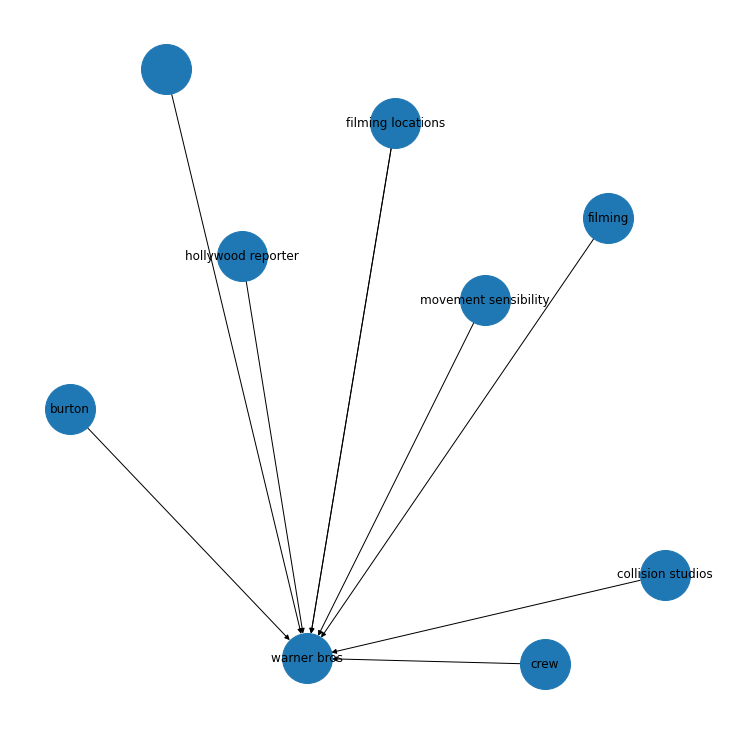

In [241]:
G = nx.from_pandas_edgelist(knowledge_graph_df[knowledge_graph_df['target']=="warner bros"],source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

In [242]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [243]:
candidate_sentences['sentence'].sample(5)

1206    pk was the first indian film to gross more than ₹7 billion and us$100 million worldwide.
2618                                                                 ... they all insist mother!
1081                             because of the film density, film speeds were necessarily slow.
664                                but many local authorities chose to ban the films regardless.
2194                                                         at least it was to zhivago himself.
Name: sentence, dtype: object

In [244]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]